# Red hat customer value predction

# Importing data and preprocessing

In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack,vstack
import xgboost as xgb
from sklearn import cross_validation as cv
from sklearn.metrics import auc
from sklearn.cross_validation import StratifiedKFold,KFold
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.optimizers import SGD,RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
import os
seed = 7
np.random.seed(seed)

/Users/Yuyang/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
Using TensorFlow backend.


In [2]:
#defining function
def clean_data(data_set):
    clean_feature = ['year_x','month_x','day_x','isweekend_x','year_y','month_y',
                     'day_y','isweekend_y','outcome','char_38_y']
    colname = data_set.columns
    for i in colname:
        if i not in clean_feature:
            if(data_set[i].dtype == 'object'):
                data_set[i] = data_set[i].fillna('type 0')
                data_set[i] = data_set[i].apply(lambda x : x.split(' ')[1]).astype(np.int32)
            elif(data_set[i].dtype == 'bool'):
                data_set[i] = data_set[i].astype(np.int8)
    return data_set

In [3]:
# Reading the data
people = pd.read_csv('./input/people.csv',dtype={'people_id':np.str,'char_38':np.int32},
                    parse_dates=['date'])
act_train = pd.read_csv('./input/act_train.csv',dtype={'people_id':np.str,'activity_id':np.str,'outcome':np.int8},
                        parse_dates=['date'])
act_test = pd.read_csv('./input/act_test.csv',dtype={'people_id':np.str,'activity_id':np.str},
                        parse_dates=['date'])
#Taking care of the date 
people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people['isweekend'] = (people['date'].dt.weekday>=5).astype(np.int8)
people = people.drop('date',axis=1)

act_train['year'] = act_train['date'].dt.year
act_train['month'] = act_train['date'].dt.month
act_train['day'] = act_train['date'].dt.day
act_train['isweekend'] = (act_train['date'].dt.weekday>=5).astype(np.int8)
act_train = act_train.drop('date',axis=1)

act_test['year'] = act_test['date'].dt.year
act_test['month'] = act_test['date'].dt.month
act_test['day'] = act_test['date'].dt.day
act_test['isweekend'] = (act_test['date'].dt.weekday>=5).astype(np.int8)
act_test = act_test.drop('date',axis=1)


In [4]:
train_people, validation_people = cv.train_test_split(people,test_size = 0.15,random_state=1)

train = act_train.merge(train_people, on='people_id', how='inner', left_index=True)
validation = act_train.merge(validation_people, on='people_id', how='inner', left_index=True)
test  = act_test.merge(people, on='people_id', how='left', left_index=True)

train = train.drop(['people_id','activity_id'],axis=1)
validation = validation.drop(['people_id','activity_id'],axis=1)
test_activity = test['activity_id']
test = test.drop(['people_id','activity_id'],axis=1)
clean_data(validation)
clean_data(train)
clean_data(test)

#del act_train,act_test,people

,activity_category,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,char_7_x,char_8_x,char_9_x,...,char_33,char_34,char_35,char_36,char_37,char_38,year_y,month_y,day_y,isweekend_y
3,1,5,10,5,1,6,1,1,7,4,...,1,1,1,1,1,76,2022,7,20,0
3,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,76,2022,7,20,0
5,1,12,1,5,4,6,1,1,13,10,...,1,1,1,1,1,90,2022,10,14,0
5,1,20,10,5,4,6,1,1,5,5,...,1,1,1,1,1,90,2022,10,14,0
5,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,90,2022,10,14,0
5,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,90,2022,10,14,0
5,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,90,2022,10,14,0
5,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,90,2022,10,14,0
5,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,90,2022,10,14,0
5,5,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,90,2022,10,14,0


In [5]:
colname = test.columns
category = ['activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x',
       'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x',
        'year_x', 'month_x', 'day_x', 
       'group_1', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y',
       'char_7_y', 'char_8_y', 'char_9_y', 'year_y', 'month_y', 'day_y']
X_train = train[category]
X_val = validation[category]
X_test_total = test[category]
y_train = train['outcome']
y_val = validation['outcome']
uncategory = []
for i in colname:
    if i not in category:
        uncategory.append(i)




## Leave no one out encoding

## Got inspired by the 'leave one out' encoding in NYC DS academy video by Owen. 
Since we have a large amount of data for each category, I don't think it necessary to leave the data point out when doing the encoding.

In [6]:
train_cate=X_train.copy()
val_cate=X_val.copy()
train_cate['result']=y_train
val_cate['result']=y_val
train_cate_first,train_cate_second,train_uncate_first,train_uncate_second= cv.train_test_split(
                                                            train_cate,train[uncategory],test_size = 0.8,random_state=2)
test_cate=X_test_total.copy()
cate_feature=test_cate.columns
for feature in cate_feature:
        #print(train_cate.groupby(feature)[[feature,'result']].agg(np.mean))
        encoder = train_cate_first.groupby(feature)[[feature,'result']].agg(np.mean)
        train_cate_second = pd.merge(train_cate_second,encoder,how='left',left_on=feature,right_on=feature)
        val_cate = pd.merge(val_cate,encoder,how='left',left_on=feature,right_on=feature)
        test_cate = pd.merge(test_cate,encoder,how='left',left_on=feature,right_on=feature)
        train_cate_second = train_cate_second.drop(feature,axis=1)
        val_cate = val_cate.drop(feature,axis=1)
        test_cate = test_cate.drop(feature,axis=1)
        train_cate_second = train_cate_second.rename(columns={'result_y':feature,'result_x':'result'})
        val_cate = val_cate.rename(columns={'result_y':feature,'result_x':'result'})
        test_cate = test_cate.rename(columns={'result':feature})
y_train = train_cate_second.result
train_cate_second=train_cate_second.drop('result',axis=1)
val_cate=val_cate.drop('result',axis=1)

In [7]:
train_cate_second.columns

Index(['activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x',
       'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x',
       'year_x', 'month_x', 'day_x', 'group_1', 'char_2_y', 'char_3_y',
       'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y',
       'year_y', 'month_y', 'day_y'],
      dtype='object')

In [8]:
# add random variable
for cate_feature in train_cate_second:
    train_cate_second[cate_feature] = train_cate_second[cate_feature]*(np.random.random(train_cate_second.shape[0])+0.5)
    val_cate[cate_feature] = val_cate[cate_feature]*(np.random.random(val_cate.shape[0])+0.5)

## Combining the feature with the numerical features

In [9]:
X_train_total = hstack((train_cate_second,train_uncate_second))
X_val_total = hstack((val_cate,validation[uncategory]))
X_test_total = hstack((test_cate,test[uncategory]))
print(X_train_total.shape)
print(X_val_total.shape)
print(X_test_total.shape)

(1477643, 58)
(350238, 58)
(498687, 58)


# Exploring the data

In [10]:
train.columns

Index(['activity_category', 'char_1_x', 'char_2_x', 'char_3_x', 'char_4_x',
       'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x',
       'outcome', 'year_x', 'month_x', 'day_x', 'isweekend_x', 'char_1_y',
       'group_1', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y',
       'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12',
       'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18',
       'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24',
       'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30',
       'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36',
       'char_37', 'char_38', 'year_y', 'month_y', 'day_y', 'isweekend_y'],
      dtype='object')

/Users/Yuyang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Yuyang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Yuyang/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


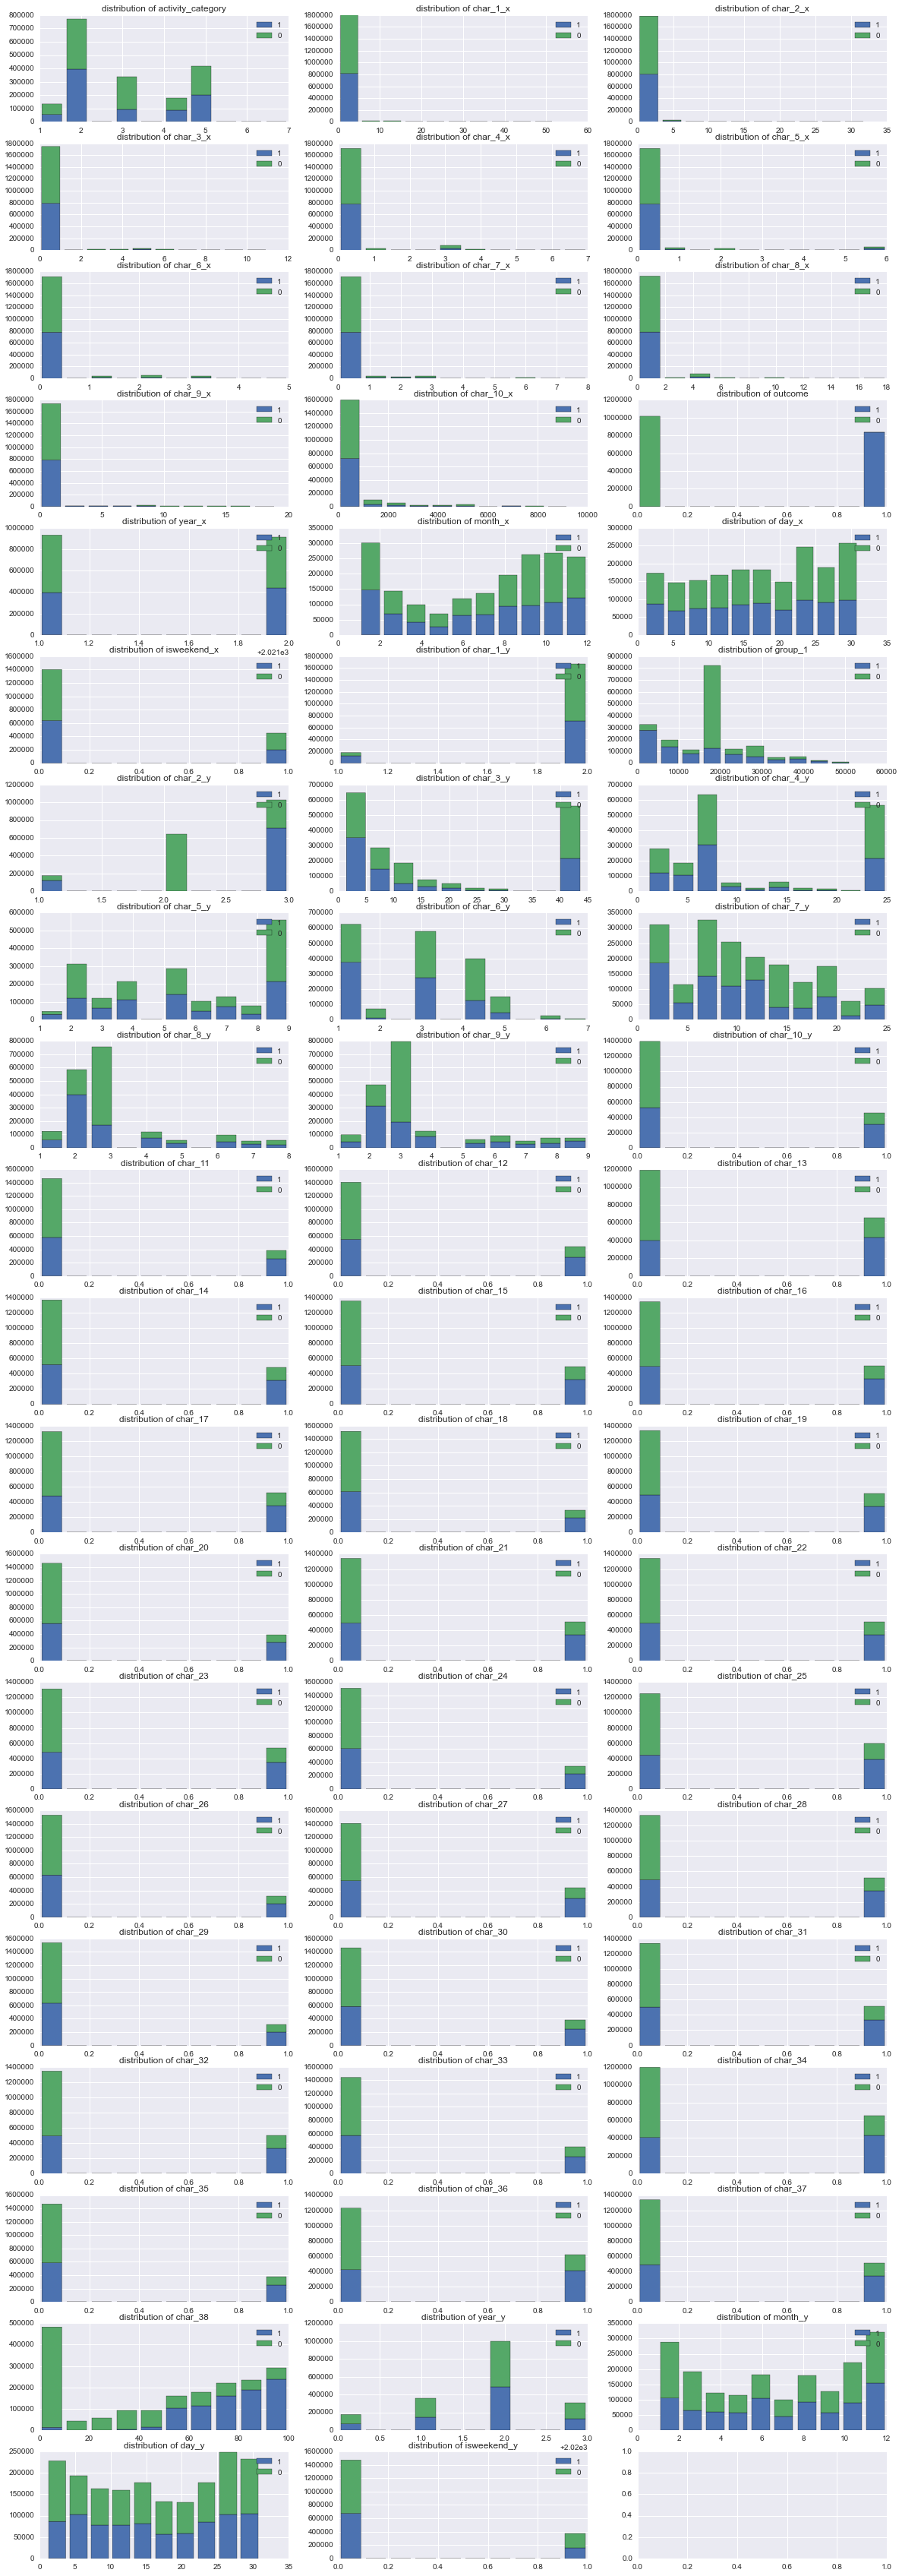

In [11]:
columns=train.columns
fig,ax = plt.subplots(nrows=int(len(columns)/3)+1,ncols=3,figsize=(20,60))
for index,column in enumerate(columns):
    ax[index/3,index%3].hist([train.loc[train.outcome==1][column],train.loc[train.outcome==0][column]],histtype='barstacked',label=[1,0])
    ax[index/3,index%3].legend()
    ax[index/3,index%3].set_title('distribution of {}'.format(column))

# Starting learning

## XGBoost

In [12]:
xg_train = xgb.DMatrix(X_train_total,label = y_train)
xg_test = xgb.DMatrix(X_val_total,label = y_val)

In [18]:
param = {'booster':'gbtree',
         'max_depth':8,
         'eta':0.1,
         'silent':0,
         'objective':'binary:logistic',
         'nthread':2,
         'eval_metric':'auc',
         #'colsample_bytree':0.92,
         #'colsample_bylevel':0.9,
         #'subsample':0.85,
         'min_child_weight':0,
         'lambda':3
        #'lambda_bias':0,
        #'alpha':1
        }
num_round = 200
watchlist = [(xg_train,'train'),(xg_test,'test')]
bst = xgb.train(param,xg_train,num_round,watchlist)
os.system("printf '\a'")

[0]	train-auc:0.975252	test-auc:0.918614
[1]	train-auc:0.975264	test-auc:0.918632
[2]	train-auc:0.975269	test-auc:0.918633
[3]	train-auc:0.975272	test-auc:0.918635
[4]	train-auc:0.975275	test-auc:0.918636
[5]	train-auc:0.977594	test-auc:0.915879
[6]	train-auc:0.977596	test-auc:0.91588
[7]	train-auc:0.977622	test-auc:0.915907
[8]	train-auc:0.977624	test-auc:0.915907
[9]	train-auc:0.977628	test-auc:0.915907
[10]	train-auc:0.977772	test-auc:0.916047
[11]	train-auc:0.977786	test-auc:0.916051
[12]	train-auc:0.977837	test-auc:0.916285
[13]	train-auc:0.977829	test-auc:0.915846
[14]	train-auc:0.977867	test-auc:0.91603
[15]	train-auc:0.977864	test-auc:0.915938
[16]	train-auc:0.977883	test-auc:0.915873
[17]	train-auc:0.977892	test-auc:0.915939
[18]	train-auc:0.977942	test-auc:0.916197
[19]	train-auc:0.977971	test-auc:0.916358
[20]	train-auc:0.977983	test-auc:0.916424
[21]	train-auc:0.978033	test-auc:0.91624
[22]	train-auc:0.978073	test-auc:0.916321
[23]	train-auc:0.978466	test-auc:0.915642
[24]	

0

### Training with all data

In [50]:
num_round = 60
X_train_all = vstack((X_train_total,X_val_total))
y_train_all = pd.concat([y_train, y_val], axis=0)
xg_train_total = xgb.DMatrix(X_train_all,label = y_train_all)
xg_test_total = xgb.DMatrix(X_test_total)
bst = xgb.train(param,xg_train_total,num_round)
ypred = bst.predict(xg_test_total)
pred_xgb = pd.DataFrame(index = test_activity, data =  ypred ,columns=['outcome'])
pred_xgb.to_csv('xgb_stacking_tree_result.csv')
os.system("printf '\a'")

0

## NNet

In [ ]:
def batch_generator(X, y, batch_size, shuffle):
    #chenglong code for fiting from generator 
    #(https://www.kaggle.com/c/talkingdata-mobile-user-demographics/forums/t/22567/neural-network-for-sparse-matrices)
    number_of_batches = np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(sample_index)
    while True:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[batch_index,:].toarray()
        y_batch = y[batch_index]
        counter += 1
        yield X_batch, y_batch
        if (counter == number_of_batches):
            if shuffle:
                np.random.shuffle(sample_index)
            counter = 0
def batch_generatorp(X, batch_size, shuffle):
    number_of_batches = X.shape[0] / np.ceil(X.shape[0]/batch_size)
    counter = 0
    sample_index = np.arange(X.shape[0])
    while True:
        batch_index = sample_index[batch_size * counter:batch_size * (counter + 1)]
        X_batch = X[batch_index, :].toarray()
        counter += 1
        yield X_batch
        if (counter == number_of_batches):
            counter = 0



In [ ]:
np.array(y_train_total)[[1,2]]

In [ ]:
def baseline_model(X_dim_input):
    # create model
    model = Sequential()
    #model.add(Dense(10, input_dim=X_train_total.shape[1], init='normal', activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(50, input_dim=X_dim_input, init='normal', activation='tanh'))
    #model.add(Dropout(0.4))
    model.add(Dense(50, input_dim=X_dim_input, init='normal', activation='relu'))
    #model.add(Dropout(0.7))
    #model.add(Dense(100, input_dim=X_dim_input, init='normal', activation='relu'))
    #model.add(Dropout(0.4))
    #model.add(Dropout(0.1))
    model.add(Dense(1, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])  #logloss
    return model
dummy_y = y_train_total
for i in range(2):
    kf = KFold(y_train_total.shape[0],n_folds = 10,random_state = i)
    score_list=[]
    val_loss_list = []
    for index,(train_cv, test_cv) in enumerate(kf):
        X_train_total[train_cv]
        X_train = X_train_total[train_cv]
        y_train = np.array(dummy_y)[train_cv]
        X_val = X_train_total[test_cv]
        y_val = np.array(dummy_y)[test_cv]
        #print(X_val.shape)
        print('*****************************************************')
        print('{}_fold'.format(index))
        model=baseline_model(X_train_total.shape[1])
        fit= model.fit_generator(generator=batch_generator(X_train, y_train, 1024*8, True),
                             nb_epoch=15,
                             samples_per_epoch=2197291,
                             validation_data=(X_val.todense(), y_val), verbose=1
                             )
        scores_val = model.predict_generator(generator=batch_generatorp(X_val, 1024*8, False), 
                                             val_samples=X_val.shape[0])
        scores = model.predict_generator(generator=batch_generatorp(X_test_total, 1024*8, False), 
                                         val_samples=X_test_total.shape[0])
        score_list.append(scores)
        val_loss = log_loss(y_val, scores_val)
        val_loss_list.append(val_loss)
        print('logloss val {}'.format(val_loss))

    for index,i in enumerate(val_loss_list):
        if(index==0):
            sumi = i
        else:
            sumi = i+sumi
    val_loss_ave = sumi/len(val_loss_list)
    print('average logloss val {}'.format(val_loss_ave))
    for index,i in enumerate(score_list):
        if(index==0):
            sumi = i
        else:
            sumi = i+sumi
    score_ave = sumi/len(score_list)
    pred = pd.DataFrame(score_ave)
    pred.to_csv('nnet_with_all_feature_100relu_softmax{}.csv'.format(val_loss_ave))